In [42]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

### Camera Caliberation Calculation

In [2]:
def get_camera_calibration(images_loc, nx, ny):
    objp = np.zeros((nx * ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.

    for idx, fname in enumerate(images_loc):
        #print(fname)
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Find the chessboard corners
        found, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        if found:
            objpoints.append(objp)
            imgpoints.append(corners)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    return mtx, dist, rvecs, tvecs

In [3]:
images_file = glob.glob('camera_cal/calibration*.jpg')
cam_mtx, cam_dist, cam_rot, cam_tran = get_camera_calibration(images_file, 9, 6) 

In [4]:
def get_undistored(img, cam_mtx, cam_dist):
    return cv2.undistort(img, cam_mtx, cam_dist, None, cam_mtx)

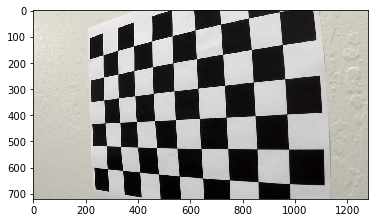

In [5]:
test_img = cv2.imread(images_file[1])
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.imshow(test_img)

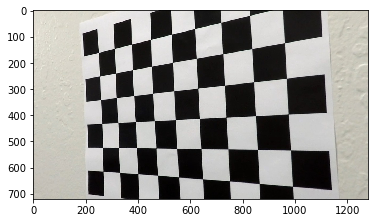

In [6]:
test_img_undist = get_undistored(test_img, cam_mtx, cam_dist)
plt.imshow(test_img_undist)

### Gradient and Thresholding of image

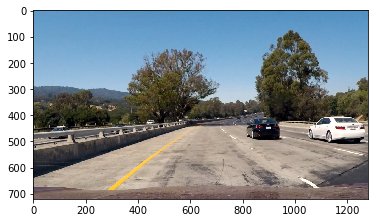

In [7]:
lane_image = cv2.imread('test_images/test1.jpg')
lane_image = cv2.cvtColor(lane_image, cv2.COLOR_BGR2RGB)
plt.imshow(lane_image)

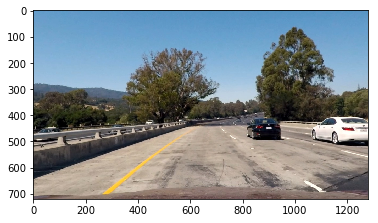

In [8]:
lane_image_undist = get_undistored(lane_image, cam_mtx, cam_dist)
plt.imshow(lane_image_undist)

In [9]:
def magnitude_gradient(img, sobel_kernel=3, thresh_min = 0, thresh_max = 255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # Take the gradient in x and y separately
    # Calculate the magnitude 
    sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    sobel_scale = np.uint8(255 * sobel/np.max(sobel)) 
    # Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(sobel_scale)
    # Return this mask as your binary_output image
    binary_output[(sobel_scale > thresh_min) & (sobel_scale <= thresh_max)] = 1
    #binary_output = np.copy(img) # Remove this line
    return binary_output

In [10]:
def direction_gradient(img, sobel_kernel=3, thresh_min=0.0, thresh_max = np.pi/2):
    # Apply the following steps to img
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(grad_dir)
    binary_output[(grad_dir > thresh_min) & (grad_dir <= thresh_max)] = 1
    return binary_output

In [11]:
def RGB_image_gradient(img, orient='x', thresh_min = 0, thresh_max = 255):
    # Convert to gray image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Derivative along axis
    if orient == 'x':
        absolute_sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
        
    if orient == 'y':
        absolute_sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * absolute_sobel/np.max(absolute_sobel))
    
    # Keeping the derivatives of interest (between of min and max threshold) and converting to binary image
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh_min) & (scaled_sobel < thresh_max)] = 1
    return binary_output
    

In [12]:
def hls_select(img, channel = 's', thresh_min = 0, thresh_max = 255):
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Apply a threshold to the S channel
    channel_idx = -1
    if channel == 'h':
        channel_idx = 0
    elif channel == 'l':
        channel_idx = 1
    elif channel == 's':
        channel_idx = 2
    simage = hls[:,:,channel_idx]
    # Return a binary image of threshold result
    binary_output = np.zeros_like(simage)
    binary_output[(simage > thresh_min) & (simage <= thresh_max)] = 1
    return binary_output

In [13]:
def rgb_select(img, channel = 'r', thresh_min = 0, thresh_max = 255):
    channel_idx = -1
    if channel == 'r':
        channel_idx = 0
    elif channel == 'g':
        channel_idx = 1
    elif channel == 'b':
        channel_idx = 2
    simage = img[:,:,channel_idx]
    # Return a binary image of threshold result
    binary_output = np.zeros_like(simage)
    binary_output[(simage > thresh_min) & (simage <= thresh_max)] = 1
    return binary_output

In [14]:
lane_image = cv2.imread('test_images/straight_lines1.jpg')
#lane_image = cv2.imread('test_images/test4.jpg')
lane_image = cv2.cvtColor(lane_image, cv2.COLOR_BGR2RGB)
lane_image_undist = get_undistored(lane_image, cam_mtx, cam_dist)

x_gradient_img = RGB_image_gradient(lane_image_undist, 'x', thresh_min=10, thresh_max=200)

y_gradient_img = RGB_image_gradient(lane_image_undist, 'y', thresh_min=20, thresh_max=200)

magnitude_gradient_img = magnitude_gradient(lane_image_undist)

direction_gradient_img = direction_gradient(lane_image_undist, sobel_kernel=15, thresh_min=0.5, thresh_max=1.5)

s_gradient_img = hls_select(lane_image_undist,channel='s', thresh_min=80, thresh_max=255)

l_gradient_img = hls_select(lane_image_undist, channel='l', thresh_min=100, thresh_max=255)

h_gradient_img = hls_select(lane_image_undist, channel='h', thresh_min=100, thresh_max=170)

r_gradient_img = rgb_select(lane_image_undist, channel='r', thresh_min=200, thresh_max=255)

g_gradient_img = rgb_select(lane_image_undist, channel='g', thresh_min=200, thresh_max=255)

b_gradient_img = rgb_select(lane_image_undist, channel='b', thresh_min=120, thresh_max=255)

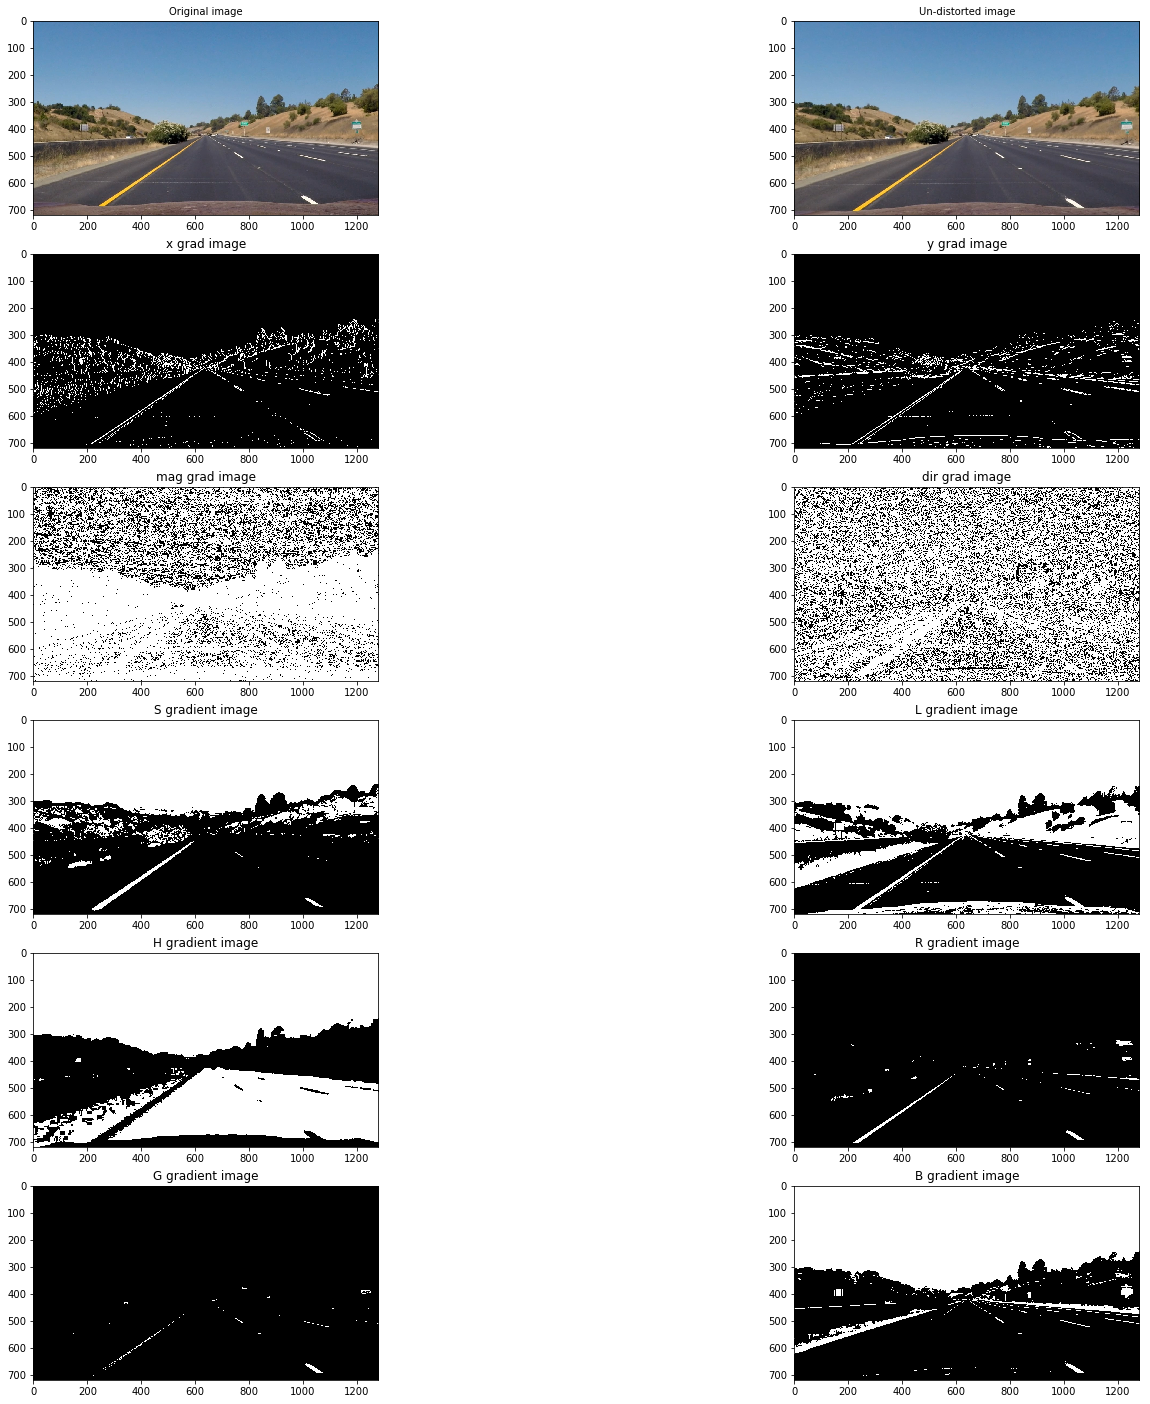

In [15]:
#Displaying all thresholding image
fig, axis = plt.subplots(6, 2, figsize=(25, 25))
axis[0, 0].imshow(lane_image)
axis[0, 0].set_title('Original image', fontsize =10)

axis[0, 1].imshow(lane_image_undist)
axis[0, 1].set_title('Un-distorted image', fontsize = 10)

axis[1, 0].imshow(x_gradient_img, 'gray')
axis[1, 0].set_title('x grad image')

axis[1, 1].imshow(y_gradient_img, 'gray')
axis[1, 1].set_title('y grad image')

axis[2, 0].imshow(magnitude_gradient_img, 'gray')
axis[2, 0].set_title('mag grad image')

axis[2, 1].imshow(direction_gradient_img, 'gray')
axis[2, 1].set_title('dir grad image')

axis[3, 0].imshow(s_gradient_img, 'gray')
axis[3, 0].set_title('S gradient image')

axis[3,1].imshow(l_gradient_img, 'gray')
axis[3,1].set_title('L gradient image')

axis[4, 0].imshow(h_gradient_img, 'gray')
axis[4, 0].set_title('H gradient image')

axis[4, 1].imshow(r_gradient_img, 'gray')
axis[4, 1].set_title('R gradient image')

axis[5, 0].imshow(g_gradient_img, 'gray')
axis[5, 0].set_title('G gradient image')

axis[5, 1].imshow(b_gradient_img, 'gray')
axis[5, 1].set_title('B gradient image')

In [16]:
yello_color = np.zeros_like(r_gradient_img)
yello_color[(r_gradient_img > 0) & (g_gradient_img > 0) & l_gradient_img > 0] = 1

In [17]:
def get_thresholded_image(img):
    # Filtering the Color part of Image. Lane could be either White or Green. 
    # This can be retrieved by putting high threshold on Red and Green. 
    # There could also be shadow part in the image. This can be removed by putting higher value on L part of HSL color model.
    
    r_select_binary = rgb_select(img=img, channel='r', thresh_min=140, thresh_max=255)
    g_select_binary = rgb_select(img=img, channel='g', thresh_min=140, thresh_max=255)
    h_remove_shadow = hls_select(img=img, channel='l', thresh_min=110, thresh_max=255)
    thresh_lane = np.zeros_like(r_select_binary)
    thresh_lane[(r_select_binary == 1) & (g_select_binary == 1) & (h_remove_shadow == 1)] = 1
    
    # S component is indepent of color. This helps to maintains the intensity component intact. 
    s_select_binary = hls_select(img,channel='s', thresh_min=100, thresh_max=255)
    
    #Also considering the only componenet which has gradient towards x direction
    x_grad_binary = RGB_image_gradient(img=img, orient='x', thresh_min=20, thresh_max=200)
    dir_grad_binary = direction_gradient(img, sobel_kernel=15, thresh_min=0.7, thresh_max=1.5)
    
    output_img = np.zeros_like(thresh_lane)
    output_img[(thresh_lane == 1) & (s_select_binary == 1) ] = 1
    return output_img

In [18]:
def get_thresholded_image_area_of_interest(img):
    thresh_img = get_thresholded_image(img)
    
    height, width = thresh_img.shape

        
    region_of_interest = np.array([[width * 0.1, height * 1.0],\
                                   [width * 0.45, height * 0.50],\
                                   [width * 0.55, height * 0.50],\
                                   [width * 0.90, height * 1.0]]).astype(int)
    
    mask = np.zeros_like(thresh_img)
    print(region_of_interest)
    cv2.fillPoly(mask, [region_of_interest], 1)
    masked_img_thresholded = cv2.bitwise_and(thresh_img, mask)
    
    return masked_img_thresholded

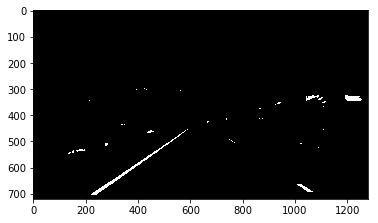

In [19]:
plt.imshow(get_thresholded_image(lane_image_undist), 'gray')

In [20]:
r_gradient_img.shape

(720, 1280)

[[ 128  720]
 [ 576  360]
 [ 704  360]
 [1152  720]]


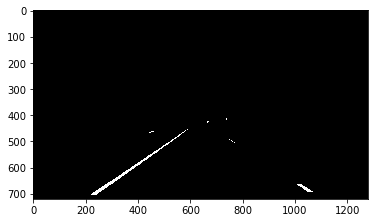

In [21]:
plt.imshow(get_thresholded_image_area_of_interest(lane_image_undist), 'gray')

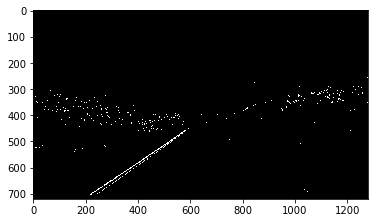

In [22]:
lane_line = np.zeros_like(x_gradient_img)
lane_line[((x_gradient_img > 0) & (direction_gradient_img > 0)) & (s_gradient_img == 1)] = 1
plt.imshow(lane_line, 'gray')

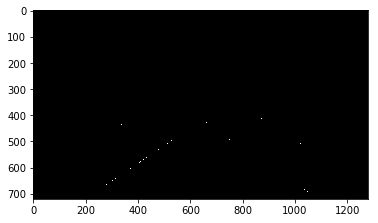

In [23]:
stacked_line = np.zeros_like(yello_color)
stacked_line[(yello_color == 1) & (lane_line == 1)] = 1
plt.imshow(stacked_line, 'gray')

### Apply perspective transform to rectify binary image

In [24]:
thresh_bin_img = get_thresholded_image_area_of_interest(lane_image_undist)

[[ 128  720]
 [ 576  360]
 [ 704  360]
 [1152  720]]


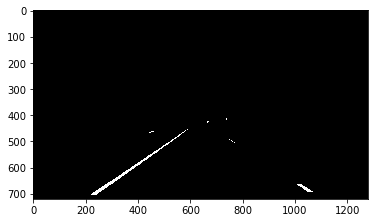

In [25]:
plt.imshow(thresh_bin_img, 'gray')

NameError: name 'x_0_img' is not defined

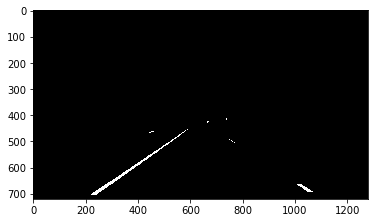

In [26]:
plt.imshow(thresh_bin_img, 'gray')
y_0_org = 680
x_0_org = x_0_img
y_1_org = y_0_org - 100
x_1_org = x_0_org
x_4_org = 1050
y_4_org = y_0_org
x_3_org = x_4_org
y_3_org = y_4_org - 120

plt.plot([x_0_org, x_1_org, x_3_org, x_4_org],[y_0_org, y_1_org, y_3_org, y_4_org])

y_0_img = 680
points = np.nonzero(thresh_bin_img[y_0_img])
x_0_img = 266

y_1_img = y_1_org + 9
x_1_img = 407

x_3_img = 880
y_3_img = y_3_org + 20

y_4_img = 670
x_4_img = 1030

#y_1_img = y_1_org
#x_1_img = np.nonzero(thresh_bin_img[y_1_img])[0][0]

plt.plot([x_0_img, x_1_img, x_3_img, x_4_img],[y_0_img, y_1_img, y_3_img, y_4_img],'*')

#plt.plot(x_0_img, y_0_img, '.')
#plt.plot(x_1_img, y_1_img, '.')

dest_point = np.float32([[x_0_org, y_0_org], [x_1_org, y_1_org], [x_3_org, y_3_org], [x_4_org, y_4_org]])
src_point = np.float32([[x_0_img, y_0_img], [x_1_img, y_1_img], [x_3_img, y_3_img], [x_4_img, y_4_img]])


In [27]:
dest_point

NameError: name 'dest_point' is not defined

In [28]:
persp_mtx = cv2.perspectiveTransform(src_point, dest_point)
warped = cv2.warpPerspective(thresh_bin_img, persp_mtx, (thresh_bin_img.shape[0], thresh_bin_img.shape[1]), flags = cv2.INTER_LINEAR)

NameError: name 'src_point' is not defined

In [29]:
persp_mtx

NameError: name 'persp_mtx' is not defined

In [30]:
thresh_bin_img[y_0_img]

NameError: name 'y_0_img' is not defined

In [31]:
bottom_left = [220,720]
bottom_right = [1110, 720]
top_left = [570, 470]
top_right = [722, 470]

source = np.float32([bottom_left,bottom_right,top_right,top_left])

bottom_left = [320,720]
bottom_right = [920, 720]
top_left = [320, 1]
top_right = [920, 1]

dst = np.float32([bottom_left,bottom_right,top_right,top_left])
M = cv2.getPerspectiveTransform(source, dst)

img_size = (thresh_bin_img.shape[1], thresh_bin_img.shape[0])
warped = cv2.warpPerspective(thresh_bin_img, M, img_size , flags=cv2.INTER_LINEAR)

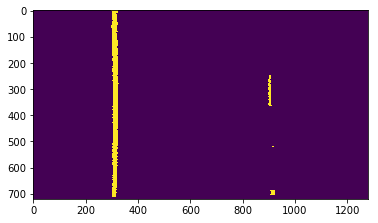

In [32]:
plt.imshow(warped)

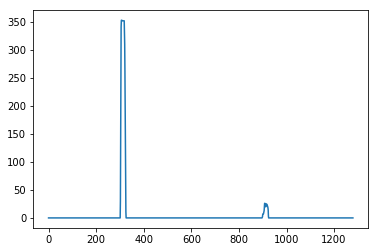

In [33]:
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [34]:
binary_warped = warped

In [35]:
def choose_pixel_of_binaryImg_by_histogram_analysis(binaryImg, x_startIndex, x_endIndex):
    histogram = np.sum(binaryImg[x_startIndex : x_endIndex, :], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_pix = np.argmax(histogram[:midpoint])
    rightx_pix = np.argmax(histogram[midpoint:]) + midpoint
    #plt.plot(histogram)
    return histogram, leftx_pix, rightx_pix

In [36]:
hist, left_pix, right_pixel = choose_pixel_of_binaryImg_by_histogram_analysis(binary_warped, 500, binary_warped.shape[0])

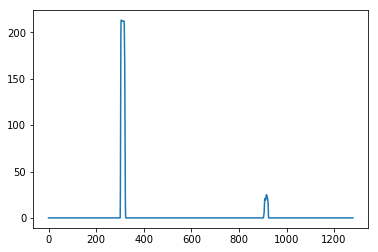

In [37]:
plt.plot(hist)

In [38]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

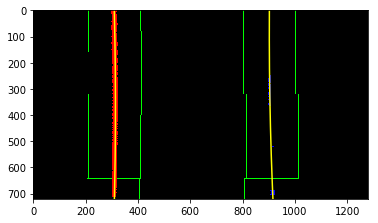

In [39]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [50]:
def lane_finding_pipeline(img):
    img_undist = get_undistored(img, cam_mtx, cam_dist)
    
    out_img = img_undist
    return out_img
    

In [51]:
def process_image(image):
    return lane_finding_pipeline(image)

In [52]:
white_output = 'project_video_withLaneMarking.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_withLaneMarking.mp4
[MoviePy] Writing video project_video_withLaneMarking.mp4


100%|█████████▉| 1260/1261 [00:24<00:00, 51.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_withLaneMarking.mp4 

CPU times: user 20.2 s, sys: 2.48 s, total: 22.6 s
Wall time: 24.9 s


In [45]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))